# Laboratorio de Datos 1ercuat 2022

## Multi-Class Text Classification LSTM (Long Short-Term Memory)

### Original - GUardar y Hacer Copia para trabajar - Estado al 31/05/2022

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from io import StringIO
import os
import re
import matplotlib.pyplot as plt
import pickle

from time import time

import warnings
warnings.filterwarnings("ignore")

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.models import load_model

import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('spanish'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py

# Depreciadoimport plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import nltk
nltk.download('stopwords')

pd.set_option('display.max_columns', False)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

debug = True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asomoza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_clases = '002_Text_Classification_clases.csv'
id_clases_df = pd.read_csv(df_clases)[0:8]
id_clases_df.drop(columns=['clase'], inplace = True )
clase_a_id = dict(id_clases_df.values)
id_a_clase = dict(id_clases_df[['id_clase','clase_original']].values)

In [3]:
df_train_file = '002_Text_train_final_sin_numeros.csv'
df_a_procesar = pd.read_csv(df_train_file)
print(df_a_procesar.shape)
df_a_procesar.head(10)

(3709, 6)


,clase_original,texto_original,texto_etl,texto_corregido,id_clase,nro_palabras
0,no_identificada,se normalizo medidor lindero XXXXXXX estado XXXXX/XXXXX cambiando tapa y acometida.,normalizo medidor lindero estado cambiando tapa acometida,se normalizo medidor lindero estado cambiando tapa y acometida,7,7
1,ok_equipo,se realizo verificacion completa se coloco caja antihurto se cambio pipeta rota energia activa: XXXXX energia reactiva: XXXXXX,realizo verificacion completa coloco caja antihurto cambio pipeta rota energia activa energia reactiva,se realizo verificacion completa se coloco caja antihurto se cambio pipeta rota energia activa energia reactiva,6,13
2,intrusion,se corto conexion directa sin medidor. en pje XXX camino Y XXXX,corto conexion directo sin medidor pje camino Y,se corto conexion directa sin medidor en pje camino Y,0,8
3,no_identificada,se cambio medidor monofasico y normaliza.,cambio medidor monofasico normalizo,se cambio medidor monofasico y normaliza,7,4
4,intrusion,se retira conexion clandestina se normaliza suministro.,retira conexion clandestina normalizo suministro,se retira conexion clandestina se normaliza suministro,0,5
5,intrusion,numerador manipulado se cambia medidor.,numerador manipulado cambio medidor,numerador manipulado se cambia medidor,0,4
6,reparacion,cambio de medidor monofasico golpeado con visor roto y tapa monofasica obsoleta.,cambio medidor monofasico golpeado con visor roto tapa monofasica obsoleta,cambio de medidor monofasico golpeado con visor roto y tapa monofasica obsoleta,1,10
7,intrusion,medidor manipulado fase y neutro invertidos la fase ingresaba por bornera de neutro y el neutro por bornera de fase se normalizo.,medidor manipulado fase neutro invertidos fase ingresaba bornera neutro neutro bornera fase normalizo,medidor manipulado fase y neutro invertidos la fase ingresaba por bornera de neutro y el neutro por bornera de fase se normalizo,0,13
8,reparacion,se encontro medidor quemado en bornera. se normaliza colocando medidor numero XXXXXXX. se realiza inspeccion completa y se coloca tapa capilla chica. se dejo presintado.,encontro medidor quemado bornera normalizo colocando medidor numero realizo inspeccion completa coloca tapa capilla chica dejo presintado,se encontro medidor quemado en bornera se normaliza colocando medidor numero se realiza inspeccion completa y se coloca tapa capilla chica se dejo presintado,1,17
9,intrusion,Se Quitó Fraude Fase X Fase. Se Normalizó El Servicio. Se Realiza Acta De Fraude.,quito fraude fase fase normalizo servicio realizo acta fraude,se quito fraude fase por fase se normalizo el servicio se realiza acta de fraude,0,9


In [4]:
print(df_a_procesar['clase_original'].value_counts())

intrusion          770
seguridad          563
reparacion         466
no_identificada    433
ok_equipo          395
market             387
sin_realizar       362
visitada           333
Name: clase_original, dtype: int64


In [5]:
print('Control de valores nulos\n-------------------------')
print('clase_original\t', df_a_procesar['clase_original'].isnull().values.any())
print('texto_original\t',df_a_procesar['texto_original'].isnull().values.any())
print('texto_etl\t',df_a_procesar['texto_etl'].isnull().values.any())
print('texto_corregido\t',df_a_procesar['texto_corregido'].isnull().values.any())
print('id_clase\t',df_a_procesar['id_clase'].isnull().values.any())
print('nro_palabras\t',df_a_procesar['nro_palabras'].isnull().values.any())

Control de valores nulos
-------------------------
clase_original	 False
texto_original	 False
texto_etl	 False
texto_corregido	 False
id_clase	 False
nro_palabras	 False


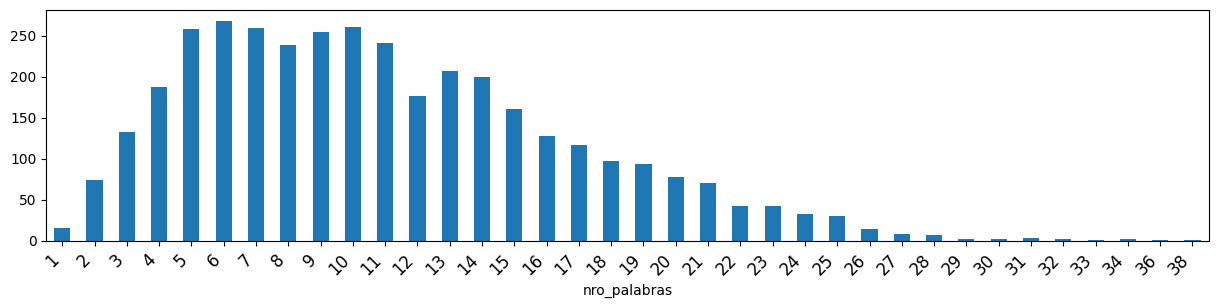

In [6]:
# Histograma del número de palabras
fig = plt.figure(figsize=(15,3))
df_a_procesar.groupby('nro_palabras').texto_original.count().plot.bar(ylim=0)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.show();

In [7]:
# Seleccion limitando la cantidad de palabras
if False:
    limite_de_palabras = 20
    df_a_procesar = df_a_procesar[df_a_procesar['nro_palabras']<=limite_de_palabras]
    print(df_a_procesar.shape)

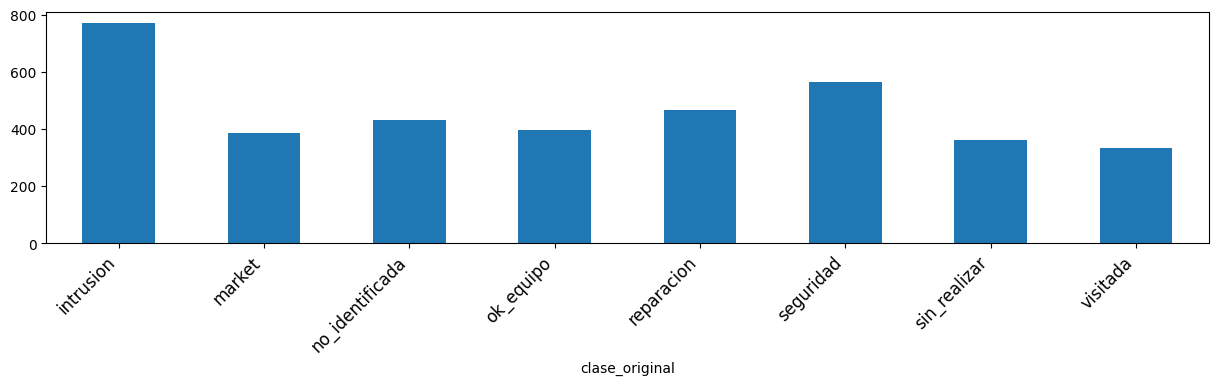

In [8]:
# Cantidad de textos por clase original
fig = plt.figure(figsize=(15,3))
df_a_procesar.groupby('clase_original').texto_original.count().plot.bar(ylim=0)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.show();

In [9]:
df_a_procesar.groupby('clase_original').texto_original.count().sort_values(ascending=False) 

clase_original
intrusion          770
seguridad          563
reparacion         466
no_identificada    433
ok_equipo          395
market             387
sin_realizar       362
visitada           333
Name: texto_original, dtype: int64

## Preparacion de Parametros para LSTM

In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_a_procesar['texto_etl'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2964 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(df_a_procesar['texto_etl'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3709, 250)


In [12]:
Y = pd.get_dummies(df_a_procesar['clase_original']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3709, 8)


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state = 42, stratify=df_a_procesar['clase_original'])
print('X_train shape =',X_train.shape,'\tY_train shape =',Y_train.shape)
print('X_test  shape =',X_test.shape,'\tY_test  shape =',Y_test.shape)


X_train shape = (2781, 250) 	Y_train shape = (2781, 8)
X_test  shape = (928, 250) 	Y_test  shape = (928, 8)


In [14]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
print(type(model))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
Total params: 5,081,208
Trainable params: 5,081,208
Non-trainable params: 0
_________________________________________________________________
None
<class 'keras.engine.sequential.Sequential'>


In [15]:
epochs = 20
batch_size = 128 #64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
20/20 [==============================] - 19s 864ms/step - loss: 2.0441 - accuracy: 0.2002 - val_loss: 1.9960 - val_accuracy: 0.1864
Epoch 2/20
20/20 [==============================] - 20s 1s/step - loss: 1.8673 - accuracy: 0.2870 - val_loss: 1.7066 - val_accuracy: 0.4122
Epoch 3/20
20/20 [==============================] - 22s 1s/step - loss: 1.5531 - accuracy: 0.5044 - val_loss: 1.4151 - val_accuracy: 0.5878
Epoch 4/20
20/20 [==============================] - 22s 1s/step - loss: 1.2491 - accuracy: 0.6299 - val_loss: 1.1660 - val_accuracy: 0.6810
Epoch 5/20
20/20 [==============================] - 22s 1s/step - loss: 0.9978 - accuracy: 0.6998 - val_loss: 1.0077 - val_accuracy: 0.6559
Epoch 6/20
20/20 [==============================] - 22s 1s/step - loss: 0.7894 - accuracy: 0.7654 - val_loss: 0.8771 - val_accuracy: 0.7419
Epoch 7/20
20/20 [==============================] - 22s 1s/step - loss: 0.6535 - accuracy: 0.8006 - val_loss: 0.8132 - val_accuracy: 0.7527
Epoch 8/20
20/20 

In [16]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Perdida: {:0.3f}\n  Exactitud: {:0.3f}'.format(accr[0],accr[1]))

29/29 [==============================] - 1s 31ms/step - loss: 0.7664 - accuracy: 0.7694
Test set
  Perdida: 0.766
  Exactitud: 0.769


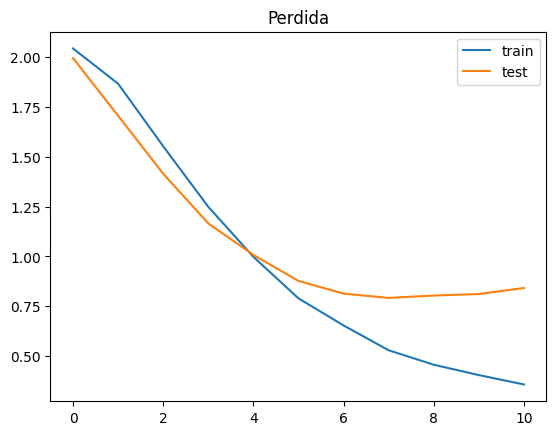

In [17]:
plt.title('Perdida')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

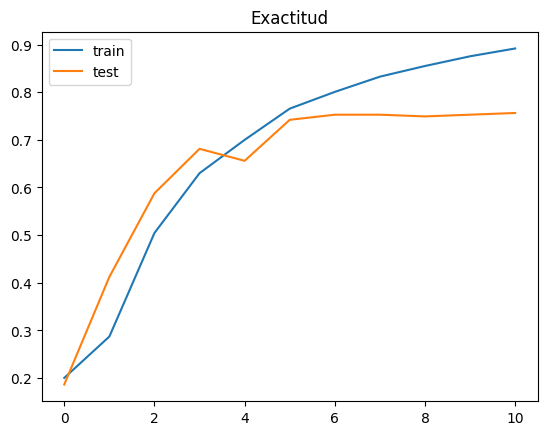

In [18]:
plt.title('Exactitud')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Salvar el modelo LSTM generado

* https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/
* 1. Saving & Loading Keras Models
* 2. https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

* If this is run on Windows then the issue is that currently toco is not supported on Windows 
* https://github.com/tensorflow/tensorflow/issues/20975

In [19]:
model_lstm = model
#modelo = '030_textos_modelo_lstm_' + str(limite_de_palabras) + '_palabras.h5'
modelo = '030_textos_modelo_lstm_todas_las_palabras.h5'
model_lstm.save(modelo)

In [20]:
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

## Testeo con archivo nuevo

In [21]:
## Eventualmente se rescata pero el rescate no esta funcionando bien
import tensorflow as tf
from tensorflow.keras.models import save_model, load_model
if False:
    model = tf.keras.models.load_model(modelo, custom_objects=None, compile=False)

In [22]:
model_lstm = model

In [30]:
df_test_file = '020_Text_predict_final_sample_1000_20220531.csv'
df_nuevo = pd.read_csv(df_test_file)
print(df_nuevo.shape)
df_nuevo.head()

(1000, 5)


,clase_original,texto_original,texto_etl,texto_corregido,id_clase
0,ok_equipo,Se encontro normal se cambio tapa rectangular chica,encontro normal cambio tapa rectangular chica,se encontro normal se cambio tapa rectangular chica,6
1,ok_equipo,A garita le pasan suministro desde vivienda. Empleado aduce que no puede tomar esa decisión y hacerse cargo. Jefe del mismo no le atendió su llamado.,garita pasan suministro desde vivienda empleado aduce no puede tomar decision hacerse cargo mismo no atendio llamado,a garita le pasan suministro desde vivienda empleado aduce que no puede tomar esa decision y hacerse cargo jefe del mismo no le atendio su llamado,6
2,seguridad,Se verifico instalacion y carga del medidor sin anomalias. se cambio tapa plastica por rota y opaca.. se adecuo.,verifico instalacion carga medidor sin anomalia cambio tapa plastica rota opaca adecuo,se verifico instalacion y carga del medidor sin anomalias se cambio tapa plastica por rota y opaca se adecuo,5
3,reparacion,Se cargó por segunda vez a womSe cambio medidor por sistema móvil trabado a causa se inundó la sala de medidores y afecto a varios se normaliza todos los afectados,cargo segunda vez womse cambio medidor sistema trabado causa inundo sala medidor afecto varios normalizo afectados,se cargo por segunda vez a womse cambio medidor por sistema movil trabado a causa se inundo la sala de medidores y afecto a varios se normaliza todos los afectados,1
4,sin_tarea,Nombre:retamar\nMovil:470\nLegajo ayudante:14091,sin determinar,nombre retamar movil legajo ayudante,7


In [31]:
df_resultado = pd.DataFrame()

nro_registros_a_procesar= 1000
i = 0

for index, row in df_nuevo.iterrows():

    clase_original = row['clase_original']
    #nuevo_texto = [row['texto_etl']]
    nuevo_texto = [row['texto_corregido']]
    seq = tokenizer.texts_to_sequences(nuevo_texto)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

    pred = model.predict(padded)
    labels = ['intrusion', 'reparacion', 'marketing', 'visitada', 'sin_realizar', 'seguridad',
          'ok_equipo', 'sin_tarea']    
    maximo = max(pred[0,0],pred[0,1],pred[0,2],pred[0,3],pred[0,4],pred[0,5],pred[0,6],pred[0,7])
    registro = {'Clase.Original':clase_original,
        'Clase.LSTM':labels[np.argmax(pred)],
        'Certeza.Maxima': maximo,
        'pr.intrusion': [pred[0,0]], 'pr.reparacion': [pred[0,1]],
        'pr.marketing':[pred[0,2]], 'pr.visitada': [pred[0,3]],      
        'pr.sin_realizar':[pred[0,4]], 'pr.seguridad': [pred[0,5]],
        'pr.ok_equipo':[pred[0,6]],'pr.sin_tarea':[pred[0,7]],
        'texto':nuevo_texto}

    #df_append = pd.DataFrame(registro)

    #df_resultado = df_resultado.append(df_append, ignore_index=True) 
    df_resultado = df_resultado.append(registro, ignore_index=True)  

    i = i + 1
    if i == nro_registros_a_procesar:
        break

In [32]:
pd.set_option('max_columns', 75)
print(df_resultado.shape)
df_resultado.head(300)

(1000, 12)


,Clase.Original,Clase.LSTM,Certeza.Maxima,pr.intrusion,pr.reparacion,pr.marketing,pr.visitada,pr.sin_realizar,pr.seguridad,pr.ok_equipo,pr.sin_tarea,texto
0,ok_equipo,seguridad,0.979831,[0.00012207948],[0.00021804571],[0.0028395173],[0.014518757],[0.0024537675],[0.97983116],[4.9159194e-06],[1.1708999e-05],[ se encontro normal se cambio tapa rectangular chica]
1,ok_equipo,ok_equipo,0.810248,[0.00023959276],[0.1845817],[0.003960853],[0.0006513458],[3.49516e-05],[0.000112277514],[0.8102479],[0.00017144982],[ a garita le pasan suministro desde vivienda empleado aduce que no puede tomar esa decision y hacerse cargo jefe del mismo no le atendio su llamado ]
2,seguridad,seguridad,0.916923,[0.001510272],[0.0020169884],[0.034251485],[0.01615637],[0.028890103],[0.9169226],[9.514357e-05],[0.0001569592],[ se verifico instalacion y carga del medidor sin anomalias se cambio tapa plastica por rota y opaca se adecuo ]
3,reparacion,sin_realizar,0.834132,[0.08344119],[0.019378759],[0.030196577],[0.00085101824],[0.834132],[0.02546756],[0.0050521065],[0.0014808266],[ se cargo por segunda vez a womse cambio medidor por sistema movil trabado a causa se inundo la sala de medidores y afecto a varios se normaliza todos los afectados]
4,sin_tarea,marketing,0.730979,[0.01746873],[0.02744228],[0.7309788],[0.0882449],[0.019792087],[0.02044655],[0.017657587],[0.077969044],[ nombre retamar movil legajo ayudante ]
...,...,...,...,...,...,...,...,...,...,...,...,...
295,ok_equipo,marketing,0.436719,[0.008086472],[0.09339081],[0.43671864],[0.009643806],[0.0030033055],[0.0023797469],[0.41398165],[0.032795556],[ se cierra desde base imposibilidad de ingresar]
296,seguridad,seguridad,0.944448,[0.0006246823],[0.00385487],[0.017242653],[0.028353343],[0.0053520286],[0.9444479],[7.658151e-05],[4.795645e-05],[ se coloco tapa rectangular chica i adecuado recinto]
297,seguridad,marketing,0.730979,[0.01746873],[0.02744228],[0.7309788],[0.0882449],[0.019792087],[0.02044655],[0.017657587],[0.077969044],[ se termino ]
298,ok_equipo,reparacion,0.899171,[0.0006567311],[0.89917135],[0.02137186],[0.060068537],[2.590601e-05],[0.0013791014],[0.0171417],[0.00018477265],[ se verifico circuito se ve sistema c sistema funciona correctamente todo medido ]


In [33]:
dataset_resultado = 'prediccion_inspecciones_lstm_completo_sample_1000_20220531.xlsx'
df_resultado.to_excel(dataset_resultado, engine='xlsxwriter')